# 최종 모델 코드

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, precision_score, recall_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter   
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
import warnings
from sklearn.cluster import KMeans

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

##### 데이터 로드

In [2]:
# data_dir = "D:\\study\\sknetworks\\team_project\\sk_2nd\\data\\"
data_dir = "C:\\KIMUJUNG\\team_project\\data\\"
df = pd.read_csv(data_dir + 'final_data.csv')
df.head(2)

,city,bd,gender,registered_via,is_churn,payment_plan_sum,plan_list_price,actual_amount_paid,discount_rate,is_auto_renew,...,transaction_count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,registration_duration,listening_duration
0,4,30,1,9,0,603,2980,3129,0.0,1.0,...,21,77,22,16,44,658,287,171508.646,2070,781
1,5,34,1,9,1,360,1072,1072,0.0,0.0,...,2,145,84,58,42,1678,1158,448313.054,2168,220


##### 전처리

In [3]:
X = df.drop(['is_churn'],axis=1)
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y ,random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

##### 오버샘플링

In [ ]:
# counter = Counter(y)
# print(counter)

# ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)
# X_res, y_res = ros.fit_resample(X, y)

# counter = Counter(y_res)
# print(counter)

# X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_train_res_scaled = scaler.fit_transform(X_train_res)
# X_test_res_scaled = scaler.transform(X_test_res)

Counter({0: 293803, 1: 62474})
Counter({0: 293803, 1: 117521})


### 의사결정나무

In [ ]:
# skf = StratifiedKFold(n_splits=5)
# dt_clf = DecisionTreeClassifier(random_state=42)
# params = {
#     # "max_depth": [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12]
# }
# gscv_tree = GridSearchCV (dt_clf, params, scoring ='accuracy', cv = skf)
# gscv_tree.fit(X_train_scaled, y_train)
# print(gscv_tree.best_estimator_)

In [4]:
stratified_kfold = StratifiedKFold(n_splits=5)
dt_clf = DecisionTreeClassifier(max_depth=11, random_state=42)

dt_accuracy = []
dt_precision = []
dt_recall = []
dt_matrix = []
dt_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    dt_clf.fit(X_train_scaled_1, y_train_1)
    y_pred_dt = dt_clf.predict(X_test_scaled_1)
    y_pred_proba = dt_clf.predict_proba(X_test_scaled_1)[:, 1]

    dt_accuracy.append(accuracy_score(y_val, y_pred_dt))
    dt_precision.append(precision_score(y_val, y_pred_dt))
    dt_recall.append(recall_score(y_val, y_pred_dt))
    dt_matrix.append(confusion_matrix(y_val, y_pred_dt))
    dt_curve.append(roc_curve(y_val, y_pred_proba))

print("의사결정나무 정확도:", round(np.mean(dt_accuracy),3))
print("의사결정나무 정밀도:", round(np.mean(dt_precision),3))
print("의사결정나무 재현율:", round(np.mean(dt_recall),3))

의사결정나무 정확도: 0.876
의사결정나무 정밀도: 0.693
의사결정나무 재현율: 0.53


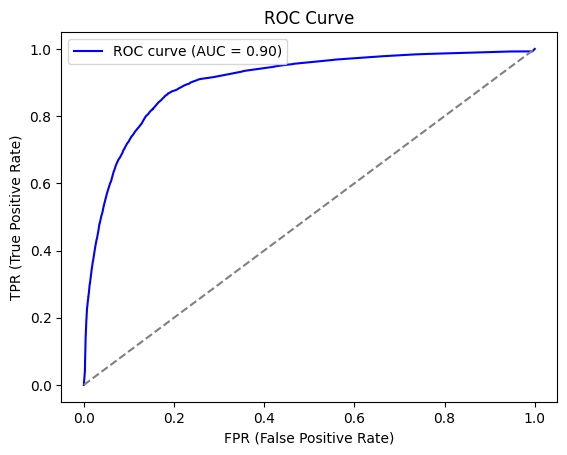

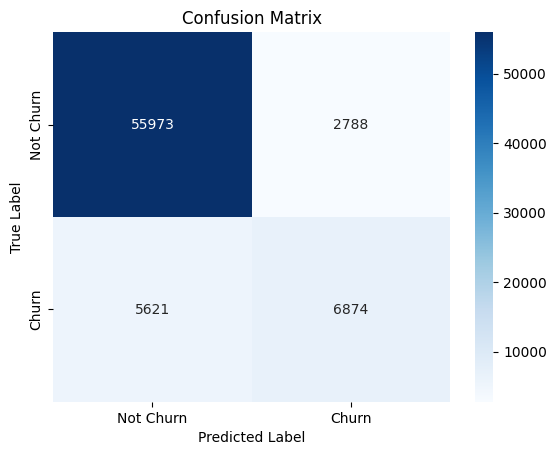

In [38]:
# ROC Curve
fpr, tpr, thresholds = dt_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = dt_matrix[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 의사결정나무 오버샘플링

In [ ]:
# skf = StratifiedKFold(n_splits=5)
# dt_clf = DecisionTreeClassifier(random_state=42)
# params = {
#     # "max_depth": [50,55,60,65,70,75,80,85,90,95,100]
#     "max_depth": [51,52,53,54,55,56,57,58,59]
#     # "max_depth": [5,10,15,20,25,30,35,40,45,50]
#     # "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12]
# }
# gscv_tree = GridSearchCV (dt_clf, params, scoring ='accuracy', cv = skf)
# gscv_tree.fit(X_train_scaled, y_train)
# print(gscv_tree.best_estimator_)

In [10]:
stratified_kfold = StratifiedKFold(n_splits=5)
dt_clf_over = DecisionTreeClassifier(max_depth=53, random_state=42)
ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)
dt_accuracy_over = []
dt_precision_over = []
dt_recall_over = []
dt_matrix_over = []
dt_curve_over = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_train_2, y_train_2 = ros.fit_resample(X_train_1, y_train_1)
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_2)
    X_test_scaled_1 = scaler.transform(X_val)

    dt_clf_over.fit(X_train_scaled_1, y_train_2)
    y_pred_dt = dt_clf_over.predict(X_test_scaled_1)   # 검증 데이터로 예측
    y_pred_proba = dt_clf_over.predict_proba(X_test_scaled_1)[:, 1]

    dt_accuracy_over.append(accuracy_score(y_val, y_pred_dt))
    dt_precision_over.append(precision_score(y_val, y_pred_dt))
    dt_recall_over.append(recall_score(y_val, y_pred_dt))
    dt_matrix_over.append(confusion_matrix(y_val, y_pred_dt))
    dt_curve_over.append(roc_curve(y_val, y_pred_proba))

print("의사결정나무 정확도:", round(np.mean(dt_accuracy_over),3))
print("의사결정나무 정밀도:", round(np.mean(dt_precision_over),3))
print("의사결정나무 재현율:", round(np.mean(dt_recall_over),3))

의사결정나무 정확도: 0.84
의사결정나무 정밀도: 0.542
의사결정나무 재현율: 0.555


In [42]:
counter = Counter(y)
print(counter)
counter = Counter(y_train_1)
print(counter)
counter = Counter(y_train_2)
print(counter)

Counter({0: 293803, 1: 62474})
Counter({0: 235043, 1: 49979})
Counter({0: 235043, 1: 94017})


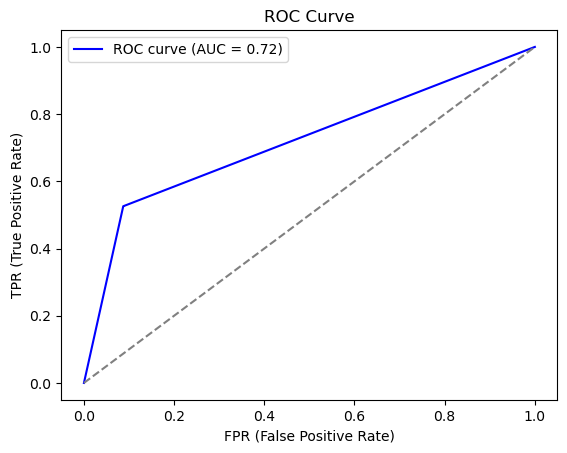

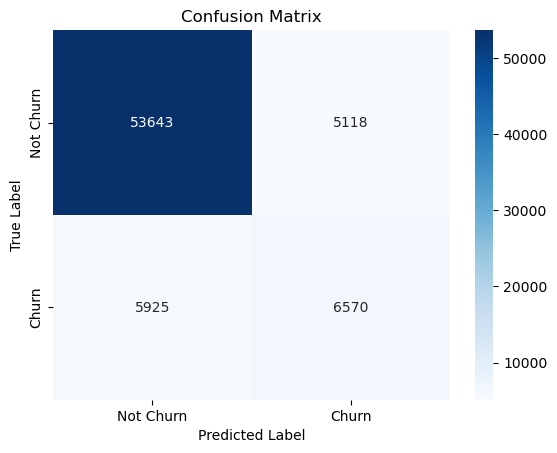

In [9]:
# ROC Curve
fpr, tpr, thresholds = dt_curve_over[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = dt_matrix_over[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 랜덤 포레스트

In [ ]:
# stratified_kfold = StratifiedKFold(n_splits=5)
# param_grid = {
#     # 'n_estimators': [50, 100, 150],       # 트리의 개수
#     # 'max_depth': [5, 10, 20, 30, 40, 50]       # 트리의 최대 깊이
#     'n_estimators': [150],       # 트리의 개수
#     # 'max_depth': [45,50,55,60,65,70]       # 트리의 최대 깊이
#     'max_depth': [46,47,48,49,50,51,52,53,54]       # 트리의 최대 깊이
# }

# # RandomForestClassifier 모델 생성
# rf_model = RandomForestClassifier(random_state=42, warm_start=True)

# # GridSearchCV를 이용한 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(rf_model, param_grid=param_grid, scoring="accuracy", cv=stratified_kfold, verbose=2, n_jobs=4)

# # 모델 학습
# grid_search.fit(X_train_scaled, y_train)

# # 최적 하이퍼파라미터 출력
# print("Best Parameters:", grid_search.best_params_)

In [46]:
stratified_kfold = StratifiedKFold(n_splits=5)
rf_clf = RandomForestClassifier(max_depth= 51, n_estimators= 150, random_state=42, warm_start=False)

rf_accuracy = []
rf_precision = []
rf_recall = []
rf_matrix = []
rf_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    rf_clf.fit(X_train_1, y_train_1)
    y_pred_rf = rf_clf.predict(X_val)
    y_pred_proba = rf_clf.predict_proba(X_val)[:, 1]

    rf_accuracy.append(accuracy_score(y_val, y_pred_rf))
    rf_precision.append(precision_score(y_val, y_pred_rf))
    rf_recall.append(recall_score(y_val, y_pred_rf))
    rf_matrix.append(confusion_matrix(y_val, y_pred_rf))
    rf_curve.append(roc_curve(y_val, y_pred_proba))

print("RF 정확도:", round(np.mean(rf_accuracy),3))
print("RF 정밀도:", round(np.mean(rf_precision),3))
print("RF 재현율:", round(np.mean(rf_recall),3))

RF 정확도: 0.884
RF 정밀도: 0.73
RF 재현율: 0.54


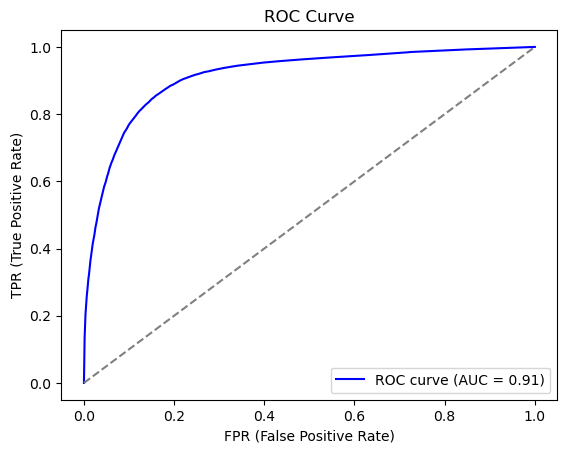

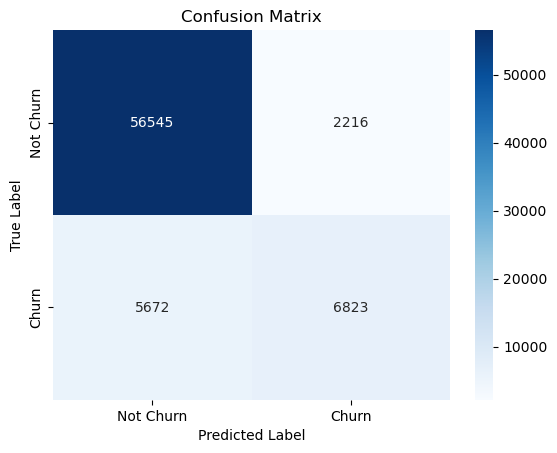

In [47]:
# ROC Curve
fpr, tpr, thresholds = rf_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_rf)
cm = rf_matrix[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 랜덤 포레스트 오버샘플링

In [ ]:
# stratified_kfold = StratifiedKFold(n_splits=5)

# param_grid = {
#     # 'n_estimators': [50, 100, 150],       # 트리의 개수
#     # 'max_depth': [5, 10, 20, 30, 40, 50]       # 트리의 최대 깊이
#     # 'max_depth': [45,50,55,60,65,70] ,      # 트리의 최대 깊이
#     # 'max_depth': [61,62,63,64,65,66,67,68,69],       # 트리의 최대 깊이
#     'max_depth': [61,62,63],       # 트리의 최대 깊이
#     'n_estimators': [100]       # 트리의 개수
# }

# # RandomForestClassifier 모델 생성
# rf_model = RandomForestClassifier(random_state=42, warm_start=True)

# # GridSearchCV를 이용한 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(rf_model, param_grid=param_grid, scoring="accuracy", cv=stratified_kfold, verbose=2, n_jobs=4)

# # 모델 학습
# grid_search.fit(X_train_res_scaled, y_train_res)

# # 최적 하이퍼파라미터 출력
# print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_depth': 62, 'n_estimators': 100}


In [20]:
stratified_kfold = StratifiedKFold(n_splits=5)
rf_clf_over = RandomForestClassifier(max_depth= 61, n_estimators= 200, random_state=42, warm_start=False)
ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)

rf_accuracy_over = []
rf_precision_over = []
rf_recall_over = []
rf_matrix_over = []
rf_curve_over = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_train_2, y_train_2 = ros.fit_resample(X_train_1, y_train_1)
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]

    rf_clf_over.fit(X_train_2, y_train_2)
    y_pred_rf = rf_clf_over.predict(X_val)
    y_pred_proba = rf_clf_over.predict_proba(X_val)[:, 1]

    rf_accuracy_over.append(accuracy_score(y_val, y_pred_rf))
    rf_precision_over.append(precision_score(y_val, y_pred_rf))
    rf_recall_over.append(recall_score(y_val, y_pred_rf))
    rf_matrix_over.append(confusion_matrix(y_val, y_pred_rf))
    rf_curve_over.append(roc_curve(y_val, y_pred_proba))

print("RF 정확도:", round(np.mean(rf_accuracy_over),3))
print("RF 정밀도:", round(np.mean(rf_precision_over),3))
print("RF 재현율:", round(np.mean(rf_recall_over),3))

RF 정확도: 0.884
RF 정밀도: 0.698
RF 재현율: 0.602


In [14]:
import pandas as pd

# Feature Importance 확인
feature_importance = rf_clf_over.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))  # 가장 영향력이 높은 10개 변수 출력

                  Feature  Importance
8           is_auto_renew    0.155012
10      transaction_count    0.096479
9               is_cancel    0.088302
19     listening_duration    0.081215
18  registration_duration    0.054995
4        payment_plan_sum    0.053828
6      actual_amount_paid    0.053157
5         plan_list_price    0.050580
11                 num_25    0.041999
16                num_unq    0.041304


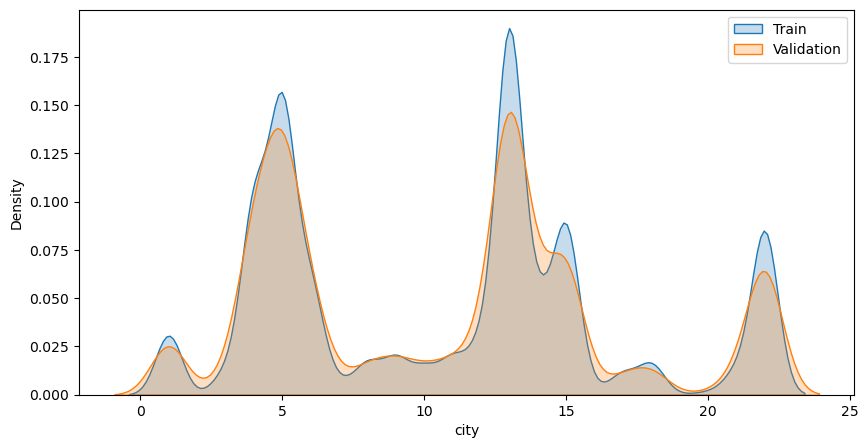

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예시: 첫 번째 Feature의 분포 확인
plt.figure(figsize=(10,5))
sns.kdeplot(X_train_2.iloc[:, 0], label="Train", fill=True)
sns.kdeplot(X_val.iloc[:, 0], label="Validation", fill=True)
plt.legend()
plt.show()

In [21]:
rf_matrix_over

[array([[55899,  2862],
        [ 4947,  7548]], dtype=int64),
 array([[55717,  3044],
        [ 5031,  7464]], dtype=int64),
 array([[55346,  3415],
        [ 5064,  7430]], dtype=int64),
 array([[55255,  3505],
        [ 4827,  7668]], dtype=int64),
 array([[55251,  3509],
        [ 4977,  7518]], dtype=int64)]

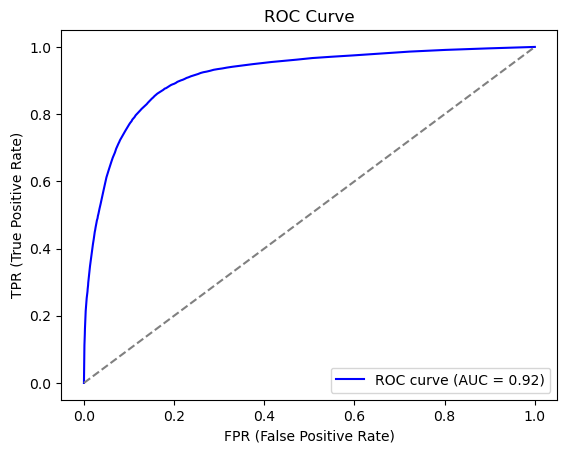

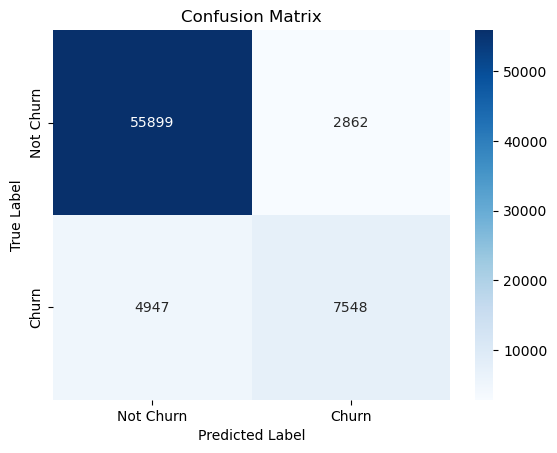

In [24]:
# ROC Curve
fpr, tpr, thresholds = rf_curve_over[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_rf)
cm = rf_matrix_over[0]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### XGBoost

In [ ]:
# # 최적의 파라미터 찾기 - GridSearchCV
# param_grid = {
#     'max_depth': [7,10,15,20,25,30],
#     'learning_rate': [0.2,0.3,0.4,0.5],
#     'n_estimators': [300, 400,500,700],
#     'subsample': [1.0],
#     'colsample_bytree': [1.0],
#     'min_child_weight': [5,7,10,15]
# }

# stratified_kfold = StratifiedKFold(n_splits=5)

# grid_search = GridSearchCV(
#     estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, tree_method="gpu_hist"),
#     param_grid=param_grid,
#     scoring='f1',
#     cv=stratified_kfold,
#     verbose=1,
#     n_jobs=-1
# )

# # GridSearchCV 실행
# grid_search.fit(X_train_scaled, y_train)

# # 최적의 파라미터 출력
# print(f"🏆 최적의 하이퍼파라미터: {grid_search.best_params_}")

In [25]:
stratified_kfold = StratifiedKFold(n_splits=5)
xgb_clf = XGBClassifier(colsample_bytree= 0.9619002092279432, gamma= 0.1743329936458647, learning_rate= 0.029852965327426227, max_depth= 11, min_child_weight= 1, n_estimators= 473, subsample= 0.8773470692601075, random_state=42)

xgb_accuracy=[]
xgb_precision=[]
xgb_recall=[]
xgb_matrix=[]
xgb_curve=[]

for train_index, val_index in stratified_kfold.split(X, y):
  X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
  X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
  scaler = StandardScaler()
  X_train_scaled_1 = scaler.fit_transform(X_train_1)
  X_test_scaled_1 = scaler.transform(X_val)

  xgb_clf.fit(X_train_scaled_1, y_train_1)
  y_pred_xgb = xgb_clf.predict(X_test_scaled_1)
  y_pred_proba = xgb_clf.predict_proba(X_test_scaled_1)[:, 1]

  xgb_accuracy.append(accuracy_score(y_val, y_pred_xgb))
  xgb_precision.append(precision_score(y_val, y_pred_xgb))
  xgb_recall.append(recall_score(y_val, y_pred_xgb))
  xgb_matrix.append(confusion_matrix(y_val, y_pred_xgb))
  xgb_curve.append(roc_curve(y_val, y_pred_proba))

print("xgboost 정확도:", round(np.mean(xgb_accuracy),3))
print("xgboost 정밀도:", round(np.mean(xgb_precision),3))
print("xgboost 재현율:", round(np.mean(xgb_recall),3))

xgboost 정확도: 0.889
xgboost 정밀도: 0.733
xgboost 재현율: 0.579


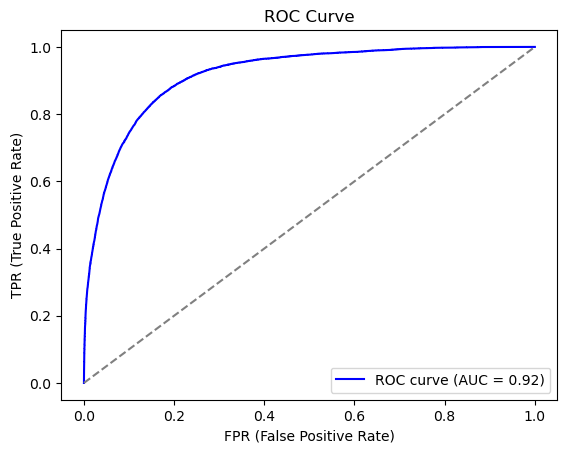

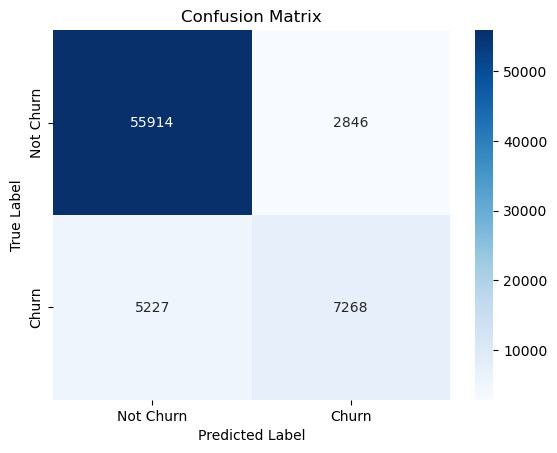

In [ ]:
# ROC Curve
fpr, tpr, thresholds = xgb_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### XGBoost 오버샘플링

In [ ]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 3, 5]
# }

# stratified_kfold = StratifiedKFold(n_splits=5)

# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     random_state=42,
#     tree_method="gpu_hist"
# )

# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=stratified_kfold,
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_res_scaled, y_res)

# # 최적의 파라미터 출력
# print(f"🏆 최적의 하이퍼파라미터: {grid_search.best_params_}")

In [12]:
stratified_kfold = StratifiedKFold(n_splits=5)
xgb_clf_over = XGBClassifier(learning_rate= 0.02, max_depth= 15, n_estimators= 400, random_state=42)
ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)

xgb_accuracy_over=[]
xgb_precision_over=[]
xgb_recall_over=[]
xgb_matrix_over=[]
xgb_curve_over=[]
xgb_model_over=[]

for train_index, val_index in stratified_kfold.split(X, y):
  X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
  X_train_2, y_train_2 = ros.fit_resample(X_train_1, y_train_1)
  X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
  scaler = StandardScaler()
  X_train_scaled_1 = scaler.fit_transform(X_train_2)
  X_test_scaled_1 = scaler.transform(X_val)
  
  xgb_clf_over.fit(X_train_scaled_1, y_train_2)
  y_pred_xgb = xgb_clf_over.predict(X_test_scaled_1)
  y_pred_proba = xgb_clf_over.predict_proba(X_test_scaled_1)[:, 1]

  xgb_accuracy_over.append(accuracy_score(y_val, y_pred_xgb))
  xgb_precision_over.append(precision_score(y_val, y_pred_xgb))
  xgb_recall_over.append(recall_score(y_val, y_pred_xgb))
  xgb_matrix_over.append(confusion_matrix(y_val, y_pred_xgb))
  xgb_curve_over.append(roc_curve(y_val, y_pred_proba))
  xgb_model_over.append(xgb_clf_over)

print("xgboost 정확도:", round(np.mean(xgb_accuracy_over),3))
print("xgboost 정밀도:", round(np.mean(xgb_precision_over),3))
print("xgboost 재현율:", round(np.mean(xgb_recall_over),3))

xgboost 정확도: 0.883
xgboost 정밀도: 0.667
xgboost 재현율: 0.665


In [14]:
dump(xgb_model_over[3], "xgb_model_over.joblib")

['xgb_model_over.joblib']

In [13]:
xgb_matrix_over

[array([[55215,  3546],
        [ 4268,  8227]], dtype=int64),
 array([[54910,  3851],
        [ 4264,  8231]], dtype=int64),
 array([[54392,  4369],
        [ 4273,  8221]], dtype=int64),
 array([[54361,  4399],
        [ 4062,  8433]], dtype=int64),
 array([[54147,  4613],
        [ 4083,  8412]], dtype=int64)]

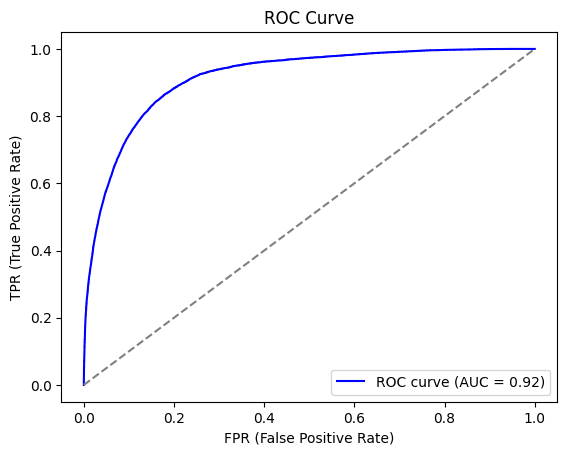

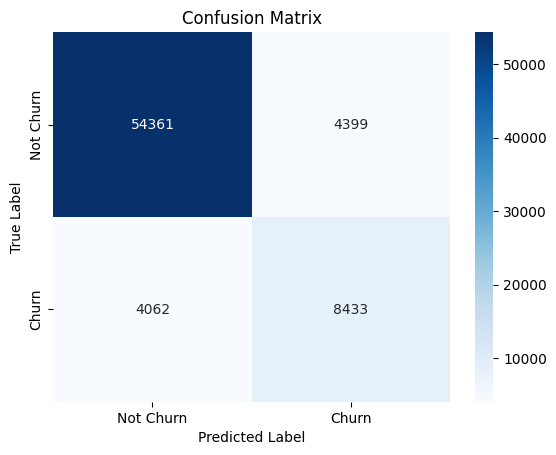

In [15]:
# ROC Curve
fpr, tpr, thresholds = xgb_curve_over[3]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
# cm = confusion_matrix(y_val, y_pred_xgb)
cm = xgb_matrix_over[3]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### LightGBM

In [ ]:
# model = lgb.LGBMClassifier()

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
#     'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
#     'n_estimators': [50, 100, 150]             # 추정기 수
# }
# skf = StratifiedKFold(n_splits=5)
# # GridSearchCV를 사용하여 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# # 훈련 데이터로 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터 출력
# print("Best hyperparameters: ", grid_search.best_params_)

In [70]:
stratified_kfold = StratifiedKFold(n_splits=5)
lgbm_clf = lgb.LGBMClassifier(learning_rate= 0.3, max_depth= 20, n_estimators= 2000, random_state=42)

lgbm_accuracy = []
lgbm_precision = []
lgbm_recall = []
lgbm_matrix = []
lgbm_curve = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_1)
    X_test_scaled_1 = scaler.transform(X_val)

    lgbm_clf.fit(X_train_scaled_1, y_train_1)
    y_pred_lgbm = lgbm_clf.predict(X_test_scaled_1)
    y_pred_proba = lgbm_clf.predict_proba(X_test_scaled_1)[:, 1]

    lgbm_accuracy.append(accuracy_score(y_val, y_pred_lgbm))
    lgbm_precision.append(precision_score(y_val, y_pred_lgbm))
    lgbm_recall.append(recall_score(y_val, y_pred_lgbm))
    lgbm_matrix.append(confusion_matrix(y_val, y_pred_lgbm))
    lgbm_curve.append(roc_curve(y_val, y_pred_proba))

print("LightGBM 정확도:", round(np.mean(lgbm_accuracy),3))
print("LightGBM 정밀도:", round(np.mean(lgbm_precision),3))
print("LightGBM 재현율:", round(np.mean(lgbm_recall),3))

[LightGBM] [Info] Number of positive: 49979, number of negative: 235042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3708
[LightGBM] [Info] Number of data points in the train set: 285021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175352 -> initscore=-1.548161
[LightGBM] [Info] Start training from score -1.548161
[LightGBM] [Info] Number of positive: 49979, number of negative: 235042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3698
[LightGBM] [Info] Number of data points in the train set: 285021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175352 -> initscore=-1.54816

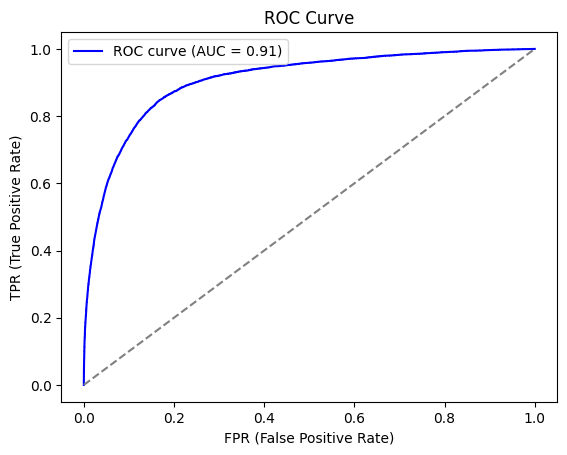

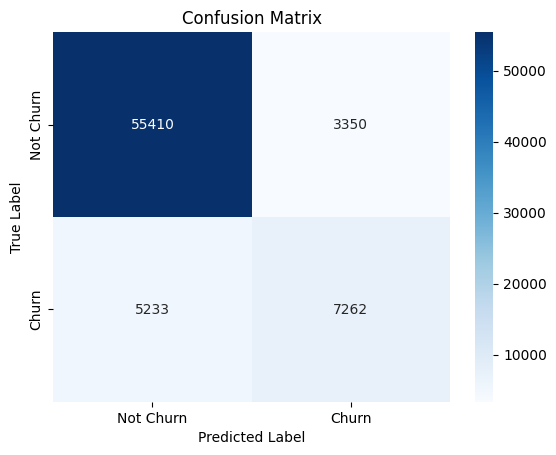

In [71]:
# ROC Curve
fpr, tpr, thresholds = lgbm_curve[0]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_lgbm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### LightGBM 오버샘플링

In [ ]:
# # LightGBM 모델 정의
# model = lgb.LGBMClassifier()

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
#     'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
#     'n_estimators': [50, 100, 150]             # 추정기 수
# }
# skf = StratifiedKFold(n_splits=5)
# # GridSearchCV를 사용하여 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# # 훈련 데이터로 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터 출력
# print("Best hyperparameters: ", grid_search.best_params_)

In [35]:
stratified_kfold = StratifiedKFold(n_splits=5)
lgbm_clf_over = lgb.LGBMClassifier(learning_rate= 0.4, max_depth= 30, n_estimators= 1500, random_state=42)
ros = RandomOverSampler(sampling_strategy=0.4, random_state=42)

lgbm_accuracy_over = []
lgbm_precision_over = []
lgbm_recall_over = []
lgbm_matrix_over = []
lgbm_curve_over = []

for train_index, val_index in stratified_kfold.split(X, y):
    X_train_1, y_train_1 = X.iloc[train_index], y.iloc[train_index]
    X_train_2, y_train_2 = ros.fit_resample(X_train_1, y_train_1)
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
  
    scaler = StandardScaler()
    X_train_scaled_1 = scaler.fit_transform(X_train_2)
    X_test_scaled_1 = scaler.transform(X_val)

    lgbm_clf_over.fit(X_train_scaled_1, y_train_2)
    y_pred_lgbm = lgbm_clf_over.predict(X_test_scaled_1)
    y_pred_proba = lgbm_clf_over.predict_proba(X_test_scaled_1)[:, 1]

    lgbm_accuracy_over.append(accuracy_score(y_val, y_pred_lgbm))
    lgbm_precision_over.append(precision_score(y_val, y_pred_lgbm))
    lgbm_recall_over.append(recall_score(y_val, y_pred_lgbm))
    lgbm_matrix_over.append(confusion_matrix(y_val, y_pred_lgbm))
    lgbm_curve_over.append(roc_curve(y_val, y_pred_proba))

print("LightGBM 정확도:", round(np.mean(lgbm_accuracy_over),3))
print("LightGBM 정밀도:", round(np.mean(lgbm_precision_over),3))
print("LightGBM 재현율:", round(np.mean(lgbm_recall_over),3))

[LightGBM] [Info] Number of positive: 94016, number of negative: 235042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 329058, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285713 -> initscore=-0.916299
[LightGBM] [Info] Start training from score -0.916299
[LightGBM] [Info] Number of positive: 94016, number of negative: 235042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3730
[LightGBM] [Info] Number of data points in the train set: 329058, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285713 -> initscore=-0.916299
[LightGBM] [Info] Start training from score -0.916299
[LightGB

In [37]:
lgbm_matrix_over

[array([[54957,  3804],
        [ 4705,  7790]], dtype=int64),
 array([[54570,  4191],
        [ 4668,  7827]], dtype=int64),
 array([[54192,  4569],
        [ 4659,  7835]], dtype=int64),
 array([[54179,  4581],
        [ 4536,  7959]], dtype=int64),
 array([[54062,  4698],
        [ 4539,  7956]], dtype=int64)]

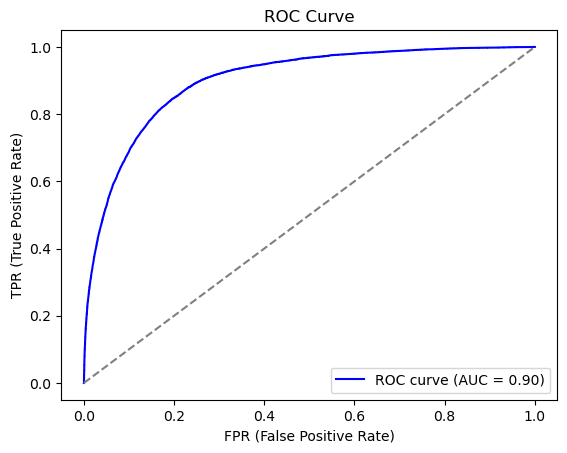

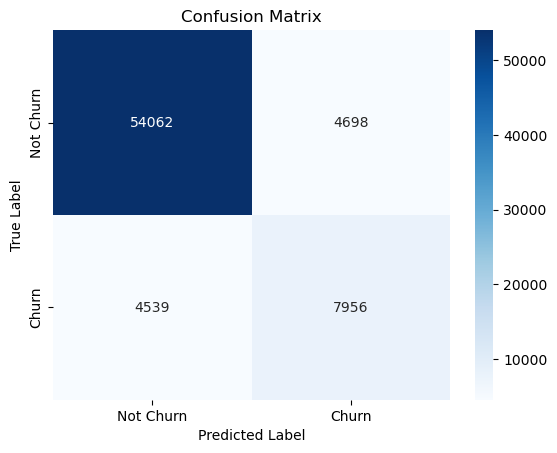

In [39]:
# ROC Curve
fpr, tpr, thresholds = lgbm_curve_over[4]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_val, y_pred_lgbm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()